In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2
model = nengo.Network()
with model:
    inp = nengo.Node(WhiteSignal(60, high=5), size_out=2)
    pre = nengo.Ensemble(60, dimensions=2)
    nengo.Connection(inp, pre)
    post = nengo.Ensemble(60, dimensions=2)
    inp_p = nengo.Probe(inp)
    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)


# Question
Do you have to know the future in order to learn?
# Todo
We want a connection without solver:

```conn = nengo.Connection(pre, post, solver=None)```

Unfortunately that is illegal syntax. Instead, we generate random decoders that result in a random `post` signal.

Also try `NoSolver()`



In [16]:
with model:
    conn = nengo.Connection(pre, post, function=lambda x: np.random.random(2), )
    weights_p = nengo.Probe(conn, "weights", synapse=0.01, sample_every=0.01)

In [ ]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

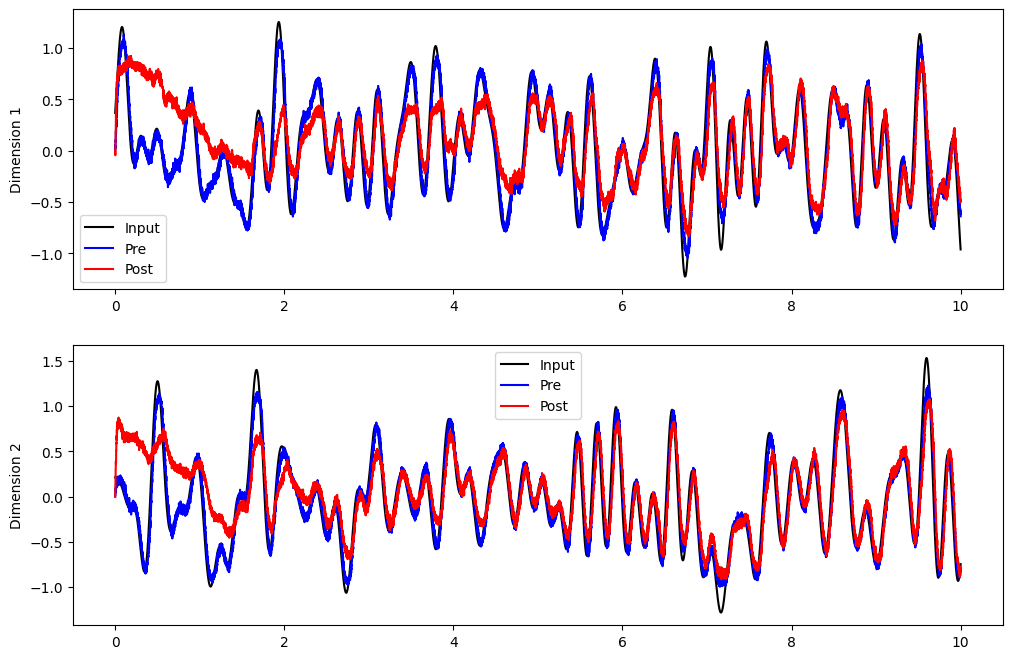

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[0], c="r", label="Post")
plt.ylabel("Dimension 1")
plt.legend(loc="best")
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[1], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[1], c="r", label="Post")
plt.ylabel("Dimension 2")
plt.legend(loc="best")

# Add learning
We override the `function` in conn by asking it to minimize an `error` ensemble.

In [13]:
with model:
    error = nengo.Ensemble(60, dimensions=2)
    error_p = nengo.Probe(error, synapse=0.03)

    # Error = actual - target = post - pre
    nengo.Connection(post, error)
    nengo.Connection(pre, error, transform=-1)

    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)

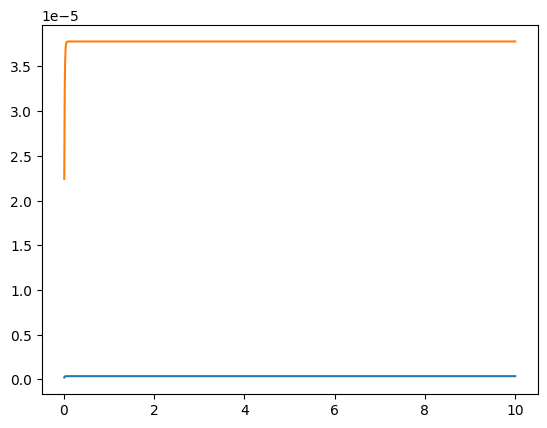

In [21]:
plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][..., 2])


In [20]:
sim.data[weights_p].shape

(1000, 2, 60)